# LAB 6 : Recurrent Neural Networks

Name : 

Roll Number : 

Referrence Material : 

1. https://github.com/pangolulu/rnn-from-scratch
2. https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/


#**Problem 1** : Next Token Prediction in a Sequence

Observation to be demonstrated:

1. Generate the data required
2. Represent tokens as indices using dictionaries
3. Convert the tokens into vectors using One hot encoding
4. Implement Recurrent Neural Network to solve the Next token prediction problem

##Write down the Objectives, Hypothesis and Experimental description for the above problem



### Objective
To implement Recurrent neural network for toy sequence.

## Programming : 


1. **Representing tokens or text**

In previous labs we mainly considered data $x \in \mathrm{R}^d$, where $d$ is the feature space dimension.
With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In this exercise we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings.

2. **One-hot encoding over vocabulary**

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given the sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$ and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will occur following 5 `a`s.

In [ ]:
import numpy as np


def generate_dataset(num_sequences=10):
    """
    Generates a number of sequences as our dataset.
    
    Input :
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    # samples = []
    
    ## Write your code here
    # for _ in range(num_sequences): 
    #   num_char = np.random.randint(1, 6)
    #   sample = ['a'] * num_char + ['b'] * num_char + ['EOS']
    #   samples.append(sample)

    sequences = []
    for i in range(10):
      z = np.random.randint(1,5)
      samples = []
      for i in range(z):
        samples.append('a')
        samples.append('b')
      samples.append('EOS')
      sequences.append(samples)    
    return sequences


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'b', 'a', 'b', 'a', 'b', 'EOS']


## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `num_words` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [ ]:
# from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Create word_to_idx and idx_to_word dictionaries for a list of sequences.
    """

    ## Write your code here
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = {'a':0,'b':0,'EOS':0}
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])
    # print(word_count)
    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sequences, vocab_size = len(sequences), len(unique_words)
    # print(vocab_size)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    word_to_idx = {}
    idx_to_word = {}

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sequences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print("Word to Index Dictionary : ",dict(word_to_idx))
print("Index to Word Dictionary : ",dict(idx_to_word))
print("Number of Sequences : ",num_sequences)
print("Vocab Size : ",vocab_size)


Word to Index Dictionary :  {'a': 0, 'b': 1, 'EOS': 2, 'UNK': 3}
Index to Word Dictionary :  {0: 'a', 1: 'b', 2: 'EOS', 3: 'UNK'}
Number of Sequences :  10
Vocab Size :  4


## Creating Dataset 

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training and test sets. 80% and 20% is a common distribution, but mind you that this largely depends on the size of the dataset. **Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.**

In [ ]:
def get_inputs_targets_from_sequences(sequences):
  # Define empty lists
  inputs, targets = [], []
  # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
  # but targets are shifted right by one so that we can predict the next word
  ## Write your code here
  for sequence in sequences:
    inputs.append(sequence[:-1])
    targets.append(sequence[1:])
  return inputs, targets

def create_datasets(sequences, p_train=0.8, p_test=0.2):
  # Define partition sizes
  num_train = int(len(sequences)*p_train)
  num_test = int(len(sequences)*p_test)
  # Split sequences into partitions
  sequences_train = sequences[:num_train]
  sequences_test = sequences[-num_test:]
  # Get inputs and targets for each partition
  inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
  inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
  
  return inputs_train,targets_train,inputs_test,targets_test
  

x_train,y_train,x_test,y_test = create_datasets(sequences)

print("Input for the first training sample : ",x_train[0])
print("Target output for the first training sample : ",y_train[0])


Input for the first training sample :  ['a', 'b', 'a', 'b', 'a', 'b']
Target output for the first training sample :  ['b', 'a', 'b', 'a', 'b', 'EOS']


## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [ ]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Input :
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Input :
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' is {test_word}.')
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' is {test_sentence}.')
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'a' is [1. 0. 0. 0.].
Our one-hot encoding of 'a' has shape (4,).
Our one-hot encoding of 'a b' is [[[1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]]].
Our one-hot encoding of 'a b' has shape (2, 4, 1).


## Implementation of RNN : 

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$


**Steps :** 

  1. Implement Forward Pass, Backward Pass and Optimisation
  2. Write the training loop
  3. Take care of the exploding gradient problem by clipping the gradients 

In [ ]:
## Write your code here
hidden_size = 50 # Number of dimensions in the hidden state
vocab_size  = len(word_to_idx) # Size of the vocabulary used

def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape[:2]
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param

def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f

def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

In [ ]:
def init_rnn(hidden_size, vocab_size):
    """
    Initializes our recurrent neural network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
    """
    # Weight matrix (input to hidden state)
    U = np.zeros((hidden_size, vocab_size))

    # Weight matrix (recurrent computation)
    V = np.zeros((hidden_size, hidden_size))

    # Weight matrix (hidden state to output)
    W = np.zeros((vocab_size, hidden_size))

    # Bias (hidden state)
    b_hidden = np.zeros((hidden_size, 1))

    # Bias (output)
    b_out = np.zeros((vocab_size, 1))
    
    # Initialize weights
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    
    # Return parameters as a tuple
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

In [ ]:
def forward_pass(inputs, hidden_state, params):
    """
    Computes the forward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `hidden_state`: an already initialized hidden state
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Create a list to store outputs and hidden states
    outputs, hidden_states = [], []
    
    # For each element in input sequence
    for t in range(len(inputs)):

        # Compute new hidden state
        hidden_state = tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)

        # Compute output
        out = softmax(np.dot(W, hidden_state) + b_out)
        
        # Save results and continue
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states


In [ ]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads


def backward_pass(inputs, outputs, hidden_states, targets, params):
    """
    Computes the backward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `outputs`: sequence of outputs from the forward pass
     `hidden_states`: sequence of hidden_states from the forward pass
     `targets`: sequence of targets
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Initialize gradients as zero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    # Keep track of hidden state derivative and loss
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    # For each element in output sequence
    # NB: We iterate backwards s.t. t = N, N-1, ... 1, 0
    for t in reversed(range(len(outputs))):

        # Compute cross-entropy loss (as a scalar)
        loss += -np.mean(np.log(outputs[t]+1e-12) * targets[t])
        
        # Backpropagate into output (derivative of cross-entropy)
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        # Backpropagate into W
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o
        
        # Backpropagate into h
        d_h = np.dot(W.T, d_o) + d_h_next
        
        # Backpropagate through non-linearity
        d_f = tanh(hidden_states[t], derivative=True) * d_h
        d_b_hidden += d_f
        
        # Backpropagate into U
        d_U += np.dot(d_f, inputs[t].T)
        
        # Backpropagate into V
        d_V += np.dot(d_f, hidden_states[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    
    # Pack gradients
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads

In [ ]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

Epoch 0, training loss: 1.647738348473118
Epoch 100, training loss: 0.5908494778717404
Epoch 200, training loss: 0.4732130907131101
Epoch 300, training loss: 0.43620040980841085
Epoch 400, training loss: 0.42019965923163116
Epoch 500, training loss: 0.41312145582114096
Epoch 600, training loss: 0.4096044322187019
Epoch 700, training loss: 0.4064204014625143
Epoch 800, training loss: 0.40333365257577064
Epoch 900, training loss: 0.4006595670588376
Epoch 1000, training loss: 0.3986626392987153
Epoch 1100, training loss: 0.39733459139798494
Epoch 1200, training loss: 0.3964351782555624
Epoch 1300, training loss: 0.39543189693437847
Epoch 1400, training loss: 0.39377539580081544
Epoch 1500, training loss: 0.39203449615866165
Epoch 1600, training loss: 0.39141765845548804
Epoch 1700, training loss: 0.39141800498396695
Epoch 1800, training loss: 0.3911638098249642
Epoch 1900, training loss: 0.3903827237775732
Input sentence:
['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b']

Target sequence:
['b', 'a

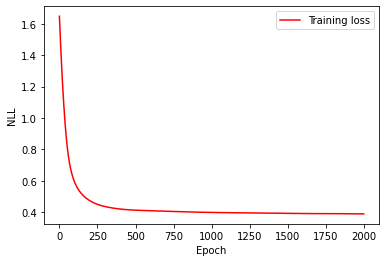

In [ ]:
import matplotlib.pyplot as plt

# Hyper-parameters
num_epochs = 2000

# Initialize a new network
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    for inputs, targets in zip(x_train,y_train):
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        if np.isnan(loss):
            raise ValueError('Gradients have vanished!')
        
        # Update parameters
        params = update_parameters(params, grads, lr=0.01)
        
        # Update loss
        epoch_training_loss += loss
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))

    # Print loss every 100 epochs
    if i % 100 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}')


# Get first sentence in test set
inputs = x_test[0]
targets = y_test[0]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [ ]:
def predict(params, sentence='', num_generate=4):
    """
    Takes in a sentence as a string and outputs a sequence
    based on the predictions of the RNN.
    
    Args:
     `params`: the parameters of the network
     `sentence`: string with whitespace-separated tokens
     `num_generate`: the number of tokens to generate
    """
    sentence = sentence.split(' ')
    
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
    
    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_size, 1))

    # Generate hidden state for sentence
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, params)
    
    # Output sentence
    output_sentence = sentence
    
    # Append first prediction
    word = idx_to_word[np.argmax(outputs[-1])]    
    output_sentence.append(word)
    
    # Forward pass
    for i in range(num_generate):

        # Get the latest prediction and latest hidden state
        output = outputs[-1]
        hidden_state = hidden_states[-1]
    
        # Reshape our output to match the input shape of our forward pass
        output = output.reshape(1, output.shape[0], output.shape[1])
    
        # Forward pass
        outputs, hidden_states = forward_pass(output, hidden_state, params)
        
        # Compute the index the most likely word and look up the corresponding word
        word = idx_to_word[np.argmax(outputs)]
        
        output_sentence.append(word)
        
    return output_sentence
    
# Perform freestyle
print('Example:')
print('a a a a a b')
print('Predicted sequence')
print(predict(params, sentence='a a a a a b'))

Example:
a a a a a b
Predicted sequence
['a', 'a', 'a', 'a', 'a', 'b', 'EOS', 'b', 'EOS', 'b', 'EOS']


## Inferences and Conclusion : State all the key observations and conclusion

#### *Results are for 2000 epochs*####  

The training loss for different learning rate is tabulated below for sequence where words are alternate (eg. ['a', 'b', 'a', 'b', 'EOS']).

\begin{array}{|c|c|c|}\hline\
  \textbf{Learning Rate} & \textbf{Training Loss} \\ \hline\
  0.5 & \text{Vanishing gradient} \\ \hline\
  0.1 & \text{Loss increases after 500 epochs} \\ \hline\
  0.01 & 0.38610 \\ \hline\
  0.001 & 0.47801 \\ \hline\
  0.0001 & 1.47949 \\ \hline
  \end{array}

The variation in loss becomes more frequent when learning rate is higher.
#############################################

The training loss for different learning rate is tabulated below for sequence where words are not alternate (eg. ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']).

\begin{array}{|c|c|c|}\hline\
  \textbf{Learning Rate} & \textbf{Training Loss} \\ \hline\
  0.5 & \text{Vanishing gradient} \\ \hline\
  0.1 & \text{Loss increases after 500 epochs} \\ \hline\
  0.01 & \text{Loss increases after 1000 epochs} \\ \hline\
  0.001 & 0.75575 \\ \hline\
  0.0001 & 1.80481 \\ \hline
  \end{array}

The variation in loss becomes more frequent when learning rate is higher.

#**Problem 2** : Demonstrate the same for a Sine Wave

Objective : Given a sequence of 50 numbers belonging to a sine wave, predict the 51st number in the series.

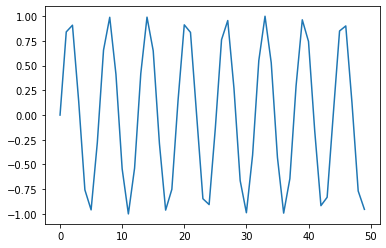

In [ ]:
## Write your code here
import math
import numpy as np
import matplotlib.pyplot as plt

sin_wave = np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])
plt.show()

In [ ]:
len(sin_wave)

200

In [ ]:
X = []
Y = []

seq_len = T =50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)
print(X.shape)
print(Y.shape)
len_data = X.shape[0]

(100, 50, 1)
(100, 1)


In [ ]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)
print(X_val.shape)
print(Y_val.shape)

(50, 50, 1)
(50, 1)


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def forward(x, y, prev_s):
    layers = []
    
    for t in range(T):
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]

        m = np.dot(U, new_input)
        n = np.dot(W, prev_s)

        o = n + m

        s = sigmoid(o)
        p = np.dot(V, s)

        layers.append({'s':s, 'prev_s':prev_s})
        prev_s = s
        
    return (m, n, o, s, p), layers

In [ ]:
def clip_min_max(dU, dV, dW):
    if dU.max() > max_clip_value:
        dU[dU > max_clip_value] = max_clip_value
    if dV.max() > max_clip_value:
        dV[dV > max_clip_value] = max_clip_value
    if dW.max() > max_clip_value:
        dW[dW > max_clip_value] = max_clip_value


    if dU.min() < min_clip_value:
        dU[dU < min_clip_value] = min_clip_value
    if dV.min() < min_clip_value:
        dV[dV < min_clip_value] = min_clip_value
    if dW.min() < min_clip_value:
        dW[dW < min_clip_value] = min_clip_value
            
    return dU, dV, dW

In [ ]:
def backward(alpha, y, layers):
    m, n, o, s, p = alpha
    
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)

    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)

    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    dp = (p - y)

    for t in range(T):
        dV_t = np.dot(dp, np.transpose(layers[t]['s']))
        dsv = np.dot(np.transpose(V), dp)

        ds = dsv
        do = sigmoid(o) * (1 - sigmoid(o)) * ds
        dn = do * np.ones_like(n)

        dprev_s = np.dot(np.transpose(W), dn)

        for j in range(t-1, max(-1, t-bptt_truncate-1), -1):
            dV_i = np.dot(dp, np.transpose(layers[j]['s']))

            ds = dsv + dprev_s
            do = sigmoid(o) * (1 - sigmoid(o)) * ds

            dn = do * np.ones_like(n)
            dm = do * np.ones_like(m)

            dW_i = np.dot(W, layers[t]['prev_s'])
            dprev_s = np.dot(np.transpose(W), dn)

            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            dU_i = np.dot(U, new_input)
            dx = np.dot(np.transpose(U), dm)

            dU_t += dU_i
            dV_t += dV_i
            dW_t += dW_i

        dU += dU_t
        dV += dV_t
        dW += dW_t
            
    return clip_min_max(dU, dV, dW)

In [ ]:
def optimize(alpha, grads):
    dU, dV, dW = grads
    U, V, W = alpha
    
    U -= learning_rate * dU
    V -= learning_rate * dV
    W -= learning_rate * dW
    
    return U, V, W

In [ ]:
def loss_fn(alpha, y):
    m, n, o, s, p = alpha
    
    return (y - p)**2 / 2

In [ ]:
def val_loss_fn(alpha):
    m, n, o, s, p = alpha
    val_loss = 0.0
    
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        alpha = forward(x, y, prev_s)

        loss_per_record = (y - p)**2 / 2
        val_loss += loss_per_record
    return val_loss / float(len_data)

In [ ]:
learning_rate = 0.001
epochs = 50
bptt_truncate = 4
min_clip_value = -1
max_clip_value = 1
hidden_dim = 100
output_dim = 1

np.random.seed(345)
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [ ]:
for epoch in range(epochs):

    loss = 0.0
    
    for i in range(len_data):
        # initialize
        x, y = X[i], Y[i]
    
        prev_s = np.zeros((hidden_dim, 1))
        
        # forward pass
        alpha, layers = forward(x, y, prev_s)
        
        # loss
        loss += loss_fn(alpha, y)
            
        # backward pass
        grads = backward(alpha, y, layers)
        
        # update
        U, V, W = optimize((U, V, W), grads)
        
    # loss
    loss = loss / float(len_data)
    
    # value loss
    if((epoch+1) % 2 == 0):
        val_loss = val_loss_fn(alpha)

        print('Epoch:{:3d}, Loss:{:12.4f}, Val_Loss:{:12.4f}'
              .format(epoch + 1, loss[0][0], val_loss[0][0]))

Epoch:  2, Loss:    605.8124, Val_Loss:    221.1228
Epoch:  4, Loss:    112.1227, Val_Loss:     23.6480
Epoch:  6, Loss:      0.1957, Val_Loss:      0.1710
Epoch:  8, Loss:      0.1383, Val_Loss:      0.1577
Epoch: 10, Loss:      0.1389, Val_Loss:      0.1456
Epoch: 12, Loss:      0.1376, Val_Loss:      0.1409
Epoch: 14, Loss:      0.1378, Val_Loss:      0.1453
Epoch: 16, Loss:      0.1415, Val_Loss:      0.1454
Epoch: 18, Loss:      0.1336, Val_Loss:      0.1367
Epoch: 20, Loss:      0.1437, Val_Loss:      0.1399
Epoch: 22, Loss:      0.1474, Val_Loss:      0.1556
Epoch: 24, Loss:      0.1415, Val_Loss:      0.1323
Epoch: 26, Loss:      0.1426, Val_Loss:      0.1482
Epoch: 28, Loss:      0.1430, Val_Loss:      0.1459
Epoch: 30, Loss:      0.1439, Val_Loss:      0.1414
Epoch: 32, Loss:      0.1507, Val_Loss:      0.1446
Epoch: 34, Loss:      0.1464, Val_Loss:      0.1435
Epoch: 36, Loss:      0.1509, Val_Loss:      0.1294
Epoch: 38, Loss:      0.1461, Val_Loss:      0.1361
Epoch: 40, L

In [ ]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.concatenate(preds).squeeze()

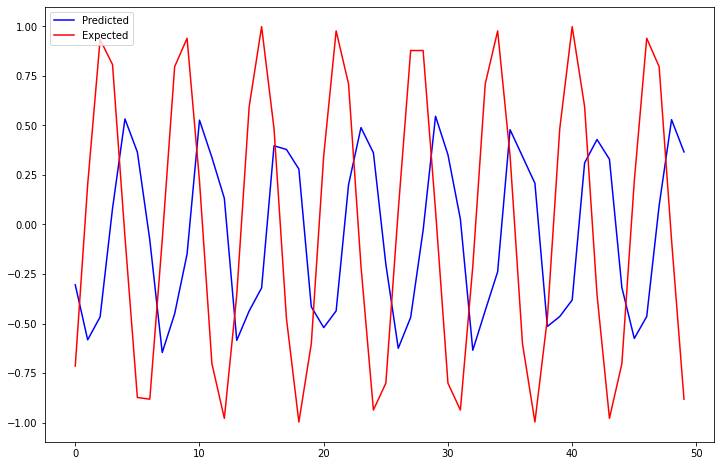

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(preds, 'b-', label='Predicted')
plt.plot(Y_val.squeeze(), 'r-', label='Expected')
plt.legend(loc="upper left")
plt.show()